Wrapping Functions
==================

In this tutorial, we will see how to wrap functions in order to make them compatible with Fiatlight.

Most of the time, functions are wrapped automatically. In the example below, the function `times_two` is wrapped
automatically by Fiatlight into a `FunctionWithGui` object:

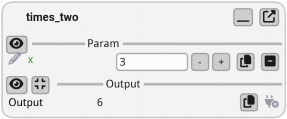

In [2]:
import fiatlight as fl
def times_two(x: int) -> int:
    return x * 2
fl.run(times_two, app_name="Times two")  # the function will be wrapped automatically into a FunctionWithGui object

> In order to be wrapped automatically, a function must have a typed signature (see [Typed signatures](#typed-signatures)).

`FunctionWithGui` is one of the core classes of FiatLight: it wraps a function with a GUI that presents its inputs and outputs.

* **Documentation**: See its [API](api_function_with_gui) for detailed information.
* **Source code**: View its full code [online](https://github.com/pthom/fiatlight/tree/refact_io/src/python/fiatlight/fiat_core/function_with_gui.py).


Typed Signatures
================

Importance of Typed Signatures
------------------------------

To automatically create a GUI for function parameters, Fiatlight **requires** type information for both the parameters and the return value of the functions. This is achieved using type hints in the function signature.

For example, an untyped function signature looks like this:

In [4]:
def foo(a, b):
    return a + b

In contrast, a typed version is:

In [5]:
def foo(a: int, b: float) -> float:
    return a + b

> More information about type hints can be found in [PEP 484](https://www.python.org/dev/peps/pep-0484/).
> _Type hints specify the type of a variable in Python. They are not mandatory but are a good practice, as they help catch bugs early in the development process._


Typed vs Untyped Functions GUI
------------------------------

In the example below, `math.sin` and `math.cos` are unfortunately not typed. `my_cos` is a wrapper around `math.cos` that includes type information.

**Code**

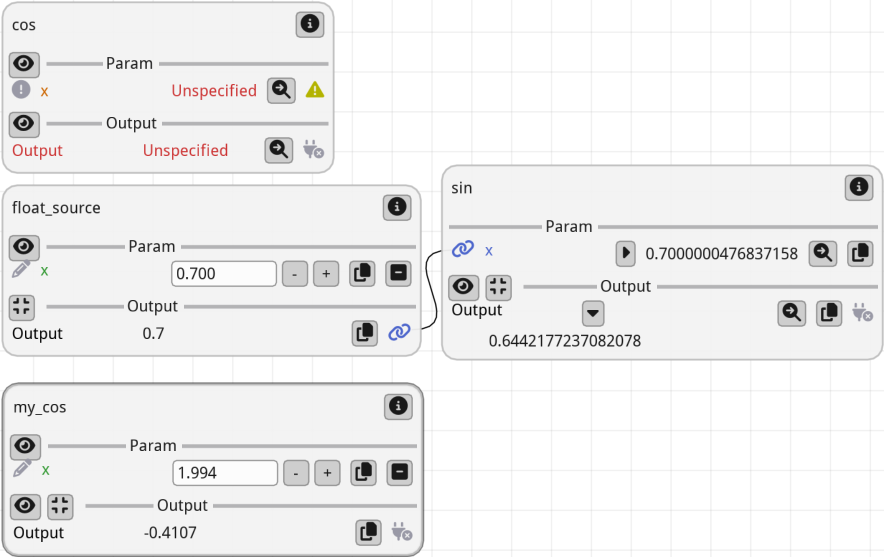

In [6]:
import math
import fiatlight as fl


def float_source(x: float) -> float:
    """A float source, where the user can specify the value of x."""
    return x


def my_cos(x: float) -> float:
    """A wrapper around math.cos that adds types,
    so that Fiatlight can infer the widgets in the GUI."""
    return math.cos(x)


# We create a graph of functions, to which we will add functions manually
graph = fl.FunctionsGraph()

# Add a node that will run math.cos: since this function has no type information,
# Fiatlight **will not** be able to infer the widgets in the GUI)
graph.add_function(math.cos)

# Add a node that will run my_cos: since this function has type information,
# Fiatlight **will** be able to infer the widgets in the GUI
graph.add_function(my_cos)

# Add a function composition that will transfer the output of float_source to math.sin
# (in this case, math.sin will work correctly, since it only has to display the numerical result,
# and does not require an edition widget)
graph.add_function_composition([float_source, math.sin])

# Run the graph
fl.run(graph, app_name="Typed Signatures")

**Visual Output**:
The image above shows the result of running the above code. Notice the differences in GUI behavior for typed vs untyped functions.

**Key Points**:
- Since `cos` is untyped, it is impossible to enter a value for its input parameter.
- The function `sin`, however, works correctly in the graph since it receives an input from `float_source` and does not require an edition widget.


Wrapping Functions
------------------

Creating a wrapper is often extremely simple and necessary when dealing with untyped functions. Wrapping a function allows you to add type information, making it compatible with Fiatlight’s GUI capabilities. Let's see how to wrap the `math.cos` function.

**Why Create a Wrapper?**

The `math.cos` function from Python's standard library does not have type annotations. Without these annotations, Fiatlight cannot automatically create a GUI for it. By creating a wrapper, we add the necessary type information.

**Example: Wrapping `math.cos`**

Below, we create a simple wrapper for `math.cos` that includes type annotations. This allows Fiatlight to generate a GUI for the function.

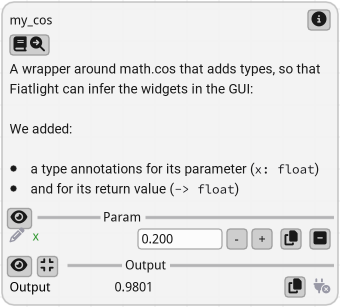

In [6]:
import math
import fiatlight as fl

# Original function without type annotations
def my_cos(x: float) -> float:
  """A wrapper around math.cos that adds types, so that Fiatlight can infer the widgets in the GUI:

  We added:
    * a type annotations for its parameter (`x: float`)
    * and for its return value (`-> float`)
  """
  return math.cos(x)

# Run the wrapped function with Fiatlight
fl.run(my_cos, app_name="Wrapped Cosine Function")

When running the above code, Fiatlight generates a GUI that allows you to input a float value for `x` and see the result of `math.cos(x)`.

_As an additional benefit, the documentation you wrote in the wrapper is visible in the function node!_


Registered Types
================

Introduction
------------

Fiatlight maintains a central registry that links data types (e.g., primitive types or custom data types) with GUI types. This registry allows Fiatlight to automatically create GUIs for functions based on their type annotations.

For more information:

* **Gui Registry**: See the [documentation](manual_registry_source) for detailed information
* **GUI Types**: The GUI Types are all descendant of `AnyDataWithGui`, which is a generic type that can be used to create custom widgets for your data types. See its [API](api_any_data_with_gui).


Using registered types
----------------------

Registered types provide dedicated widgets, enabling automatic GUI creation for function parameters and outputs.

> Tip: use the command `fiatlight types` in a terminal (or console) to list the registered types and their associated widgets. See "[Fiatlight command line utility](manual_cli)" for more information.

Below is an extract of the output of the `fiatlight types` command:

    > fiatlight types
    +----------------------------------------------------+-----------------------------------------------------------------------+
    | Data Type                                          | Gui Type                                                              |
    +====================================================+=======================================================================+
    | int                                                | IntWithGui                                                            |
    |                                                    |   A highly customizable int widget.                                   |
    +----------------------------------------------------+-----------------------------------------------------------------------+
    | float                                              | FloatWithGui                                                          |
    |                                                    |   A highly customizable float widget.                                 |
    +----------------------------------------------------+-----------------------------------------------------------------------+
    | str                                                | StrWithGui                                                            |
    |                                                    |   A Gui for a string with resizable input text, with a popup for      |
    |                                                    | multiline editing.                                                    |
    +----------------------------------------------------+-----------------------------------------------------------------------+
    | bool                                               | BoolWithGui                                                           |
    |                                                    |   A bool widget. Can use a checkbox or a toggle.                      |
    +----------------------------------------------------+-----------------------------------------------------------------------+
    | ColorRgb                                           | ColorRgbWithGui                                                       |
    |   synonym for tuple[int, int, int] describing an   |   A nice color picker for RGB colors (int)                            |
    | RGB color, with values in [0, 255] (NewType)       |                                                                       |
    +----------------------------------------------------+-----------------------------------------------------------------------+
    | ...                                                | ...                                                                   |


Example with Matplotlib Figures
-------------------------------

Let's look at an example using `TextPath` and `matplotlib.figure.Figure`, which are registered types in Fiatlight:

- `fl.fiat_types.TextPath` is an alias for str, but it is registered to be displayed with a file selection dialog.
- `matplotlib.figure.Figure` is registered to be displayed as a plot in the GUI

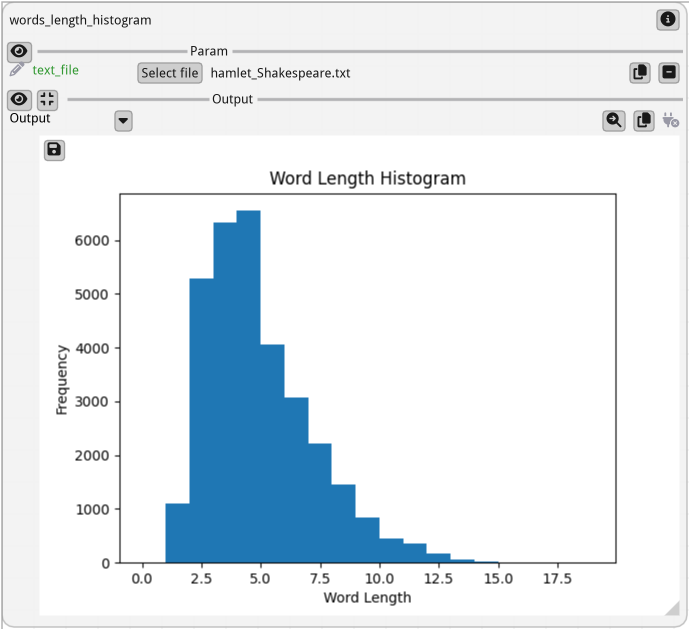

In [7]:
import fiatlight as fl
import matplotlib.figure
import matplotlib.pyplot as plt

def words_length_histogram(text_file: fl.fiat_types.TextPath) -> matplotlib.figure.Figure:
    "Create a histogram of the lengths of words in a text file."
    with open(text_file) as f:
        text = f.read()
    words = text.split()
    lengths = [len(word) for word in words]
    fig, ax = plt.subplots()
    ax.hist(lengths, bins=range(0, 20))
    ax.set_title("Word Length Histogram")
    ax.set_xlabel("Word Length")
    ax.set_ylabel("Frequency")
    return fig


fl.run(words_length_histogram, app_name="Registered types")

Controlling Function Execution
==============================

By default, the function will be called only when one of its inputs has changed (either because the user
entered a new value, or because an input is connected to another function that has changed).

You can control the behavior of the function by setting attributes on the function object.

* `invoke_async` (default=False): if set to True, the function will be called asynchronously
* `invoke_manually` (default=False): if set to True, the function will be called only if the user clicks on the "invoke" button
* `invoke_always_dirty` (default=False): if set to True, the function output will always be considered out of date. Depending on the value of `invoke_manually`:
  - if "invoke_manually" is True, the "Refresh needed" label will be displayed
  - if "invoke_manually" is False, the function will be called at each frame

> _Note: a "live" function is thus a function with `invoke_manually=False` and `invoke_always_dirty=True`_


Configuring "Live" functions
----------------------------

**Example: a live function that display a camera image**

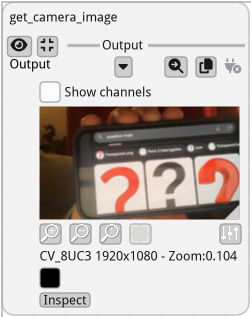

In [20]:
import fiatlight as fl
from fiatlight.fiat_kits.fiat_image import ImageU8_3
import cv2  # we use OpenCV to capture the camera image (pip install opencv-python)
cap = cv2.VideoCapture(0)  # you will need a camera!

def get_camera_image() -> ImageU8_3 | None:
    ret, frame = cap.read()
    return ImageU8_3(frame) if ret else None

# Set flags to make this a live function (called automatically at each frame)
fl.add_fiat_attributes(get_camera_image, invoke_always_dirty=True)

fl.run(get_camera_image, app_name="Live camera image")

Using Async Functions
---------------------

**Example: an async function**

When your function is slow, you can set the `invoke_async` flag to True. In the example below, the yellow spinner indicates that the function is running, while keeping the GUI responsive.

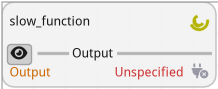

In [5]:
import fiatlight as fl
import time
def slow_function() -> int:
    time.sleep(5)
    return 42

fl.add_fiat_attributes(slow_function, invoke_async=True)
fl.run(slow_function, app_name="Async function")

# Note:
# You can also use the `@fl.with_fiat_attributes` decorator to set the flags directly on the function:
# @fl.with_fiat_attributes(invoke_async=True)
# def slow_function() -> int:
#    ...

"Stoppable" async Functions
---------------------
In the case of async function, you may also set:
* `invoke_async_stoppable`(default=False): if true a GUI button will be displayed to stop the async function while it is running.

In this case, you will need to check the flag `invoke_async_shall_stop` in your function to know if the function should stop.

**Example:**

In [6]:
def my_async_function():
    # ...  # some initialization
    while True:  # inner loop of the function processing (can be any form of loop)
        # ...  # some processing
        if hasattr(my_async_function, "invoke_async_shall_stop") and my_async_function.invoke_async_shall_stop:
            my_async_function.invoke_async_shall_stop = False  # reset the flag
            break
        # ... # continue the function processing

Manual Invocation Example
-------------------------

**Example: a function that needs to be called manually**

If you set the `invoke_manually` flag to True, the function will be called only when the user clicks the "invoke" button (indicated by a "recycle" icon). If the inputs have changed, a "Refresh needed" label will be displayed.

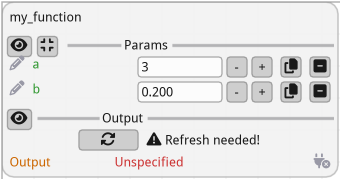

In [7]:
import fiatlight as fl
def my_function(a: int, b: float) -> float:
    return a + b

fl.add_fiat_attributes(my_function, invoke_manually=True)
fl.run(my_function, app_name="Manual invocation")

Handwriting the GUI
===================

Using Edit and Present Callbacks
--------------------------------

You can also customize the GUI for a parameter or output by setting custom callbacks function, namely the "edit" and "present" callbacks.

In this case, you will first wrap the function in a `FunctionWithGui` object, and then set the callbacks for the parameter or output.

In [8]:
import fiatlight as fl

def my_function(a: int) -> float:
    return a * 4

my_function_gui = fl.FunctionWithGui(my_function)

# A callback to edit the parameter. Receive the current value, and return a tuple (bool, new_value)
# my_function_gui.input("a").callbacks.edit = ...

# A callback to present the output. Receive the current value, and return None
# my_function_gui.output().callbacks.present = ...

For more information, see:

* **AnyDataWithGui**: See the [API](api_any_data_with_gui.ipynb) for detailed information.
* **AnyDataWithGuiCallbacks**: See the [API](api_any_data_gui_callbacks.ipynb) for detailed information.


Example: Custom Callbacks
-------------------------

In this example, we define custom edit and present callbacks for the function fahrenheit_to_celsius. The resulting GUI allows the user to input a temperature in Fahrenheit using a custom slider and see the converted temperature in Celsius with a color-coded note indicating whether it is cold, warm, or hot.

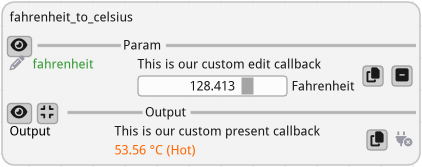

In [9]:
import fiatlight as fl
from imgui_bundle import imgui, hello_imgui, ImVec4


def fahrenheit_to_celsius(fahrenheit: float = 0) -> float:
    return (fahrenheit - 32) * 5 / 9

# This will be our edit callback: it accepts a float and returns a tuple (bool, float)
# where the first element is True if the value has changed, and the second element is the new value
def edit_temperature(fahrenheit: float) -> tuple[bool, float]:
    imgui.text("This is our custom edit callback")
    # Set the width of the slider field to 10 em units (using em units is a good practice to make the GUI dpi aware)
    imgui.set_next_item_width(hello_imgui.em_size(10))
    changed, new_value = imgui.slider_float("Fahrenheit", fahrenheit, -100, 200)
    return changed, new_value

# This will be our present callback: it accepts a float and returns None
def present_temperature(celsius: float) -> None:
    imgui.text("This is our custom present callback")
    note = "Cold" if celsius < 20 else "Hot" if celsius > 40 else "Warm"
    color = ImVec4(0, 0.4, 1, 1) if celsius < 20 else ImVec4(1, 0.4, 0, 1) if celsius > 40 else ImVec4(0, 1, 0, 1)
    imgui.text_colored(color, f"{celsius:.2f} °C ({note})")


fahrenheit_to_celsius_gui = fl.FunctionWithGui(fahrenheit_to_celsius)
fahrenheit_to_celsius_gui.output().callbacks.present = present_temperature
fahrenheit_to_celsius_gui.input("fahrenheit").callbacks.edit = edit_temperature

fl.run(fahrenheit_to_celsius_gui, app_name="Custom callbacks")